In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU
from numpy import array
plt.rcParams['figure.figsize'] = [20, 8]

In [37]:
df = pd.read_csv('../Dataset/Gold.csv')
df = df.sort_index(ascending=False)
df

,Date,Open,Close,High,Low
1693,3/1/2019,1314.460,1292.765,1315.105,1290.355
1692,3/2/2019,1292.765,1292.765,1292.765,1292.765
1691,3/3/2019,1292.765,1292.765,1292.765,1292.765
1690,3/4/2019,1295.910,1286.710,1297.105,1283.160
1689,3/5/2019,1287.410,1287.775,1289.550,1281.460
...,...,...,...,...,...
4,3/22/2024,2181.340,2165.400,2186.050,2157.450
3,3/23/2024,2165.400,2165.400,2165.400,2165.400
2,3/24/2024,0.000,2165.990,2167.890,2165.300
1,3/25/2024,2166.820,2172.300,2181.000,2163.970


In [38]:
df['Close'].isnull().sum()

0

In [39]:
df = df.reset_index()['Close']

In [40]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df).reshape(-1,1))

In [41]:
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [42]:
import numpy
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]  
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [43]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [44]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [45]:
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [46]:
model.fit(X_train, y_train, validation_data = (X_test, ytest), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
20/20 [==============================] - 12s 137ms/step - loss: 0.0973 - val_loss: 0.0088
Epoch 2/100
20/20 [==============================] - 1s 76ms/step - loss: 0.0097 - val_loss: 0.0231
Epoch 3/100
20/20 [==============================] - 2s 80ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 4/100
20/20 [==============================] - 2s 92ms/step - loss: 0.0031 - val_loss: 0.0058
Epoch 5/100
20/20 [==============================] - 2s 95ms/step - loss: 0.0023 - val_loss: 0.0043
Epoch 6/100
20/20 [==============================] - 2s 87ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 7/100
20/20 [==============================] - 2s 90ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 8/100
20/20 [==============================] - 2s 83ms/step - loss: 9.3946e-04 - val_loss: 0.0010
Epoch 9/100
20/20 [==============================] - 2s 88ms/step - loss: 7.3632e-04 - val_loss: 5.9517e-04
Epoch 10/100
20/20 [==============================] - 2s 82ms/step - loss: 6.3033e-04 

In [47]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

8/8 [==============================] - 0s 19ms/step


In [48]:
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)

In [49]:
train_size1 = int(0.8 * len(df))
test_size1 = len(df) - train_size

train_data1 = df[:train_size]
test_data1 = df[train_size:]

x_test1 = np.array(test_data1.index).reshape(-1, 1)
y_test1 = np.array(test_data1)

In [50]:
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test1)**2))
print('Testing RMSE:', test_rmse)

#MSE
test_mse = np.mean((y_pred - y_test1)**2)
print('Testing MSE:', test_mse)

#MAPE
test_mape = np.mean(np.abs((y_test1 - y_pred) / y_test1)) * 100
print('Testing MAPE:', test_mape)

#MAE
test_mae = np.mean(np.abs(y_pred - y_test1))
print('Testing MAE:', test_mae)

Testing RMSE: 106.65603342638384
Testing MSE: 11375.509466249907
Testing MAPE: 4.200769148101796
Testing MAE: 83.5825954031796


In [51]:
lst_output=[]
n_steps=100
i=0

x_input = test_data[len(test_data) - n_steps:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()


while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.9646476]
101
1 day input [0.81208738 0.82621437 0.81722935 0.83225806 0.84015887 0.84015887
 0.84015887 0.84015887 0.84307874 0.86634104 0.85328753 0.85293328
 0.85030326 0.85030326 0.84637432 0.82754549 0.82962804 0.83216145
 0.83216145 0.83216145 0.81395524 0.81544737 0.81071333 0.81435242
 0.83557512 0.83557512 0.83557512 0.84175836 0.81355805 0.78981268
 0.80777199 0.81480328 0.81480328 0.81480328 0.80626912 0.81433095
 0.79822876 0.8053674  0.80302721 0.80302721 0.80253341 0.81746551
 0.82266116 0.82491546 0.84176909 0.82459342 0.82459342 0.82459342
 0.80965058 0.82175943 0.82065375 0.81982717 0.80921046 0.80921046
 0.80921046 0.80451935 0.77567495 0.77416134 0.78726853 0.79735924
 0.79735924 0.79735924 0.80111642 0.80883474 0.8107348  0.80933927
 0.82158768 0.82158768 0.82158768 0.81653159 0.81572648 0.82004187
 0.83060491 0.87273898 0.87273898 0.87273898 0.90585583 0.92034781
 0.94217165 0.9547421  0.97386077 0.97386077 0.97424722 0.9775106
 0.9537867  0.97085503 0.95645966 0

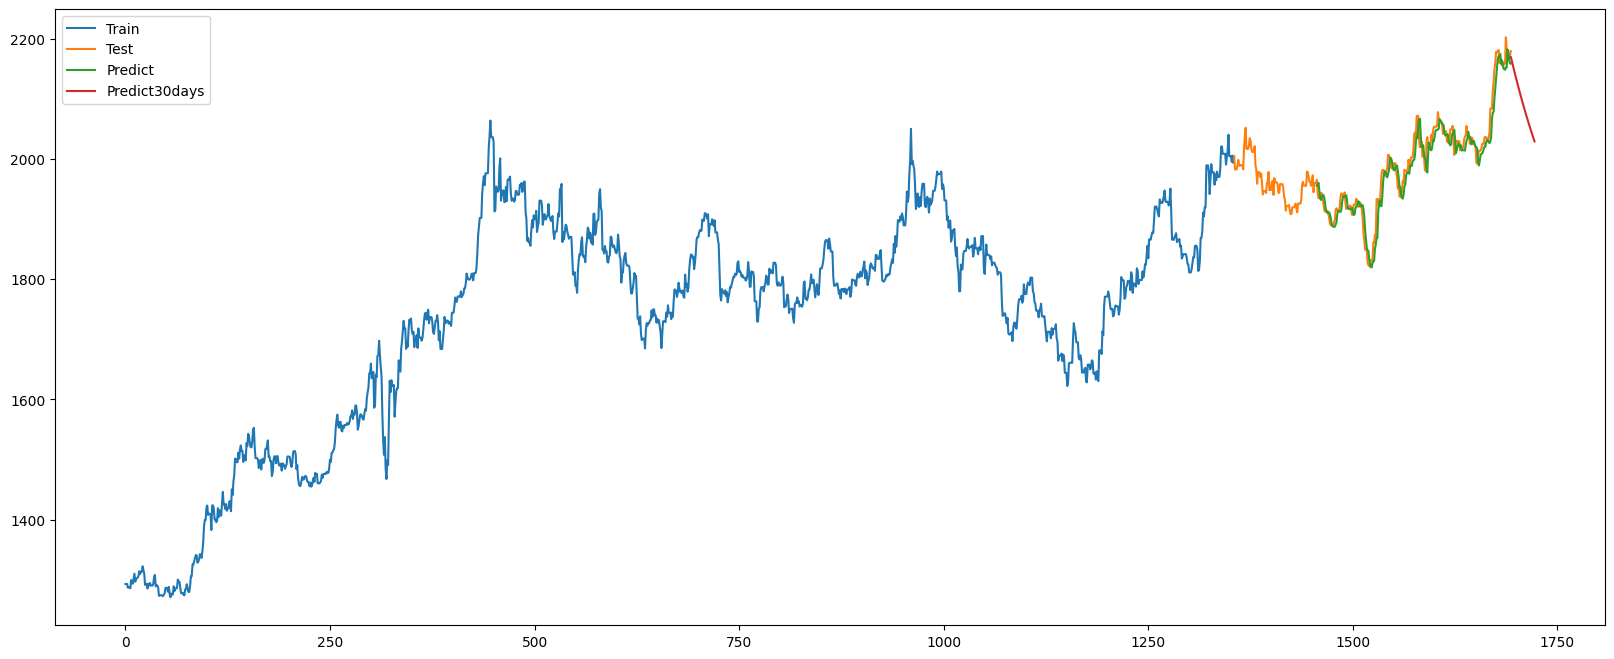

<Figure size 2000x800 with 0 Axes>

In [52]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','Predict','Predict30days'])
plt.figure()
plt.show()